# 论文阅读

目标检测领域：从目标检测开始火到detr都很少有端到端的方法，大部分方法最后至少需要后处理操作（NMS,non-maximum suppression非极大值抑制）

无论是proposal based方法、anchor based方法、non-anchor based方法，最后都会生成很多预测框，如何去除这些冗余的框就是NMS要做的事情

问题：

1、而有了NMS，模型调参就会很复杂，

2、而且即使训练好了一个模型，部署起来也非常困难（NMS不是所有硬件都支持）

解决：

1、不需要proposal、不需要anchor，直接利用transformer这种全局建模的能力，把目标检测看做是**集合预测**问题

2、因为有了这种全局建模的能力，detr**不会有那么多冗余框**，最后**出什么结果就是什么结果**，不需要NMS做后处理，让模型的训练和部署简单不少

> 集合预测：目标检测本来任务就是给定一个图像，预测一堆框，每个框不仅要知道的其坐标，还要知道框里包含物体的类别，这些框就是一个集合，不同的图像对应的集合也是不同的，给定一个图片，我要预测这个集合

## 两大创新点
1、把目标检测做成一个端到端的框架，

把之前特别依赖人的先验知识的部分删掉了（NMS部分、anchor），一旦把这两个部分拿掉之后，我们也不用费尽心思设计这种anchor，最后不会出现这么多框，不会用到NMS，也不会用到很多超参去调


2、新的目标函数，通过二分图匹配的方式，强制模型输出一组独一无二的预测（没有那么多冗余框，每个物体理想状态下就会生成一个框）

3、使用encoder-decoder的架构 

## 两个小贡献：

1、decoder还有另外一个输入learned object query，类似anchor的意思

（给定这些object query之后，detr就可以把learned object query和全局图像信息结合一起，通过不同的做注意力操作，从而让模型直接输出最后的一组预测框）

2、想法&&实效性：最后的结果是并行输出的，并行比串行更合适，并不是检测一个大物体前必须先检测一个小物体，或从左到右检测，我们希望越快越好

## 好处：

1、简单性：想法上简单，不需要一个特殊的library，只要硬件支持transformer或CNN，就一定支持detr

2、性能：在coco数据集上，detr和一个训练非常好的faster RCNN基线网络取得了差不多的效果，模型内存和速度也和faster RCNN差不多

3、别的任务：全景分割任务上detr效果很好，detr能够非常简单拓展到其他任务上

## 流程（训练）：

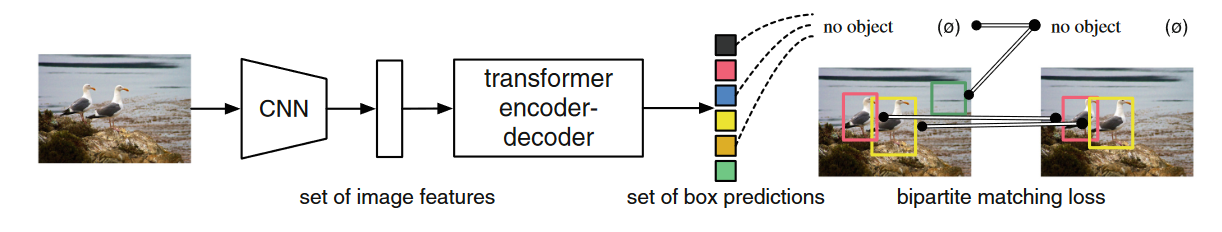

1、CNN提特征 

2、特征拉直，送到encoder-decoder中，encoder作用：进一步学习全局信息，为近下来的decoder，也就是最后出预测框做铺垫

3、decoder生成框的输出，当你有了图像特征之后，还会有一个object query（限定了你要出多少框），通过query和特征在decoder里进行自注意力操作，得到输出的框（文中是100，无论是什么图片都会预测100个框）

4、loss ：二分图匹配，计算100个预测的框和2个GT框的matching loss，决定100个预测框哪两个是独一无二对应到红黄色的GT框，匹配的框去算目标检测的loss

推理

1、2、3一致，第四步loss不需要，直接在最后的输出上用一个阈值卡一个输出的置信度，置信度比较大（>0.7的）保留，置信度小于0.7的当做背景物体

## 结果

1、detr对大物体预测很准，归功于transformer，能进行全局建模（原来使用anchor的话就会受限于anchor大小）

2、缺陷：对小物体效果不好（多尺度、多特征，可以提高小物体的检测）

3、detr训练很慢，500个epoch（coco大多数模型一般训练几十个epoch就行）

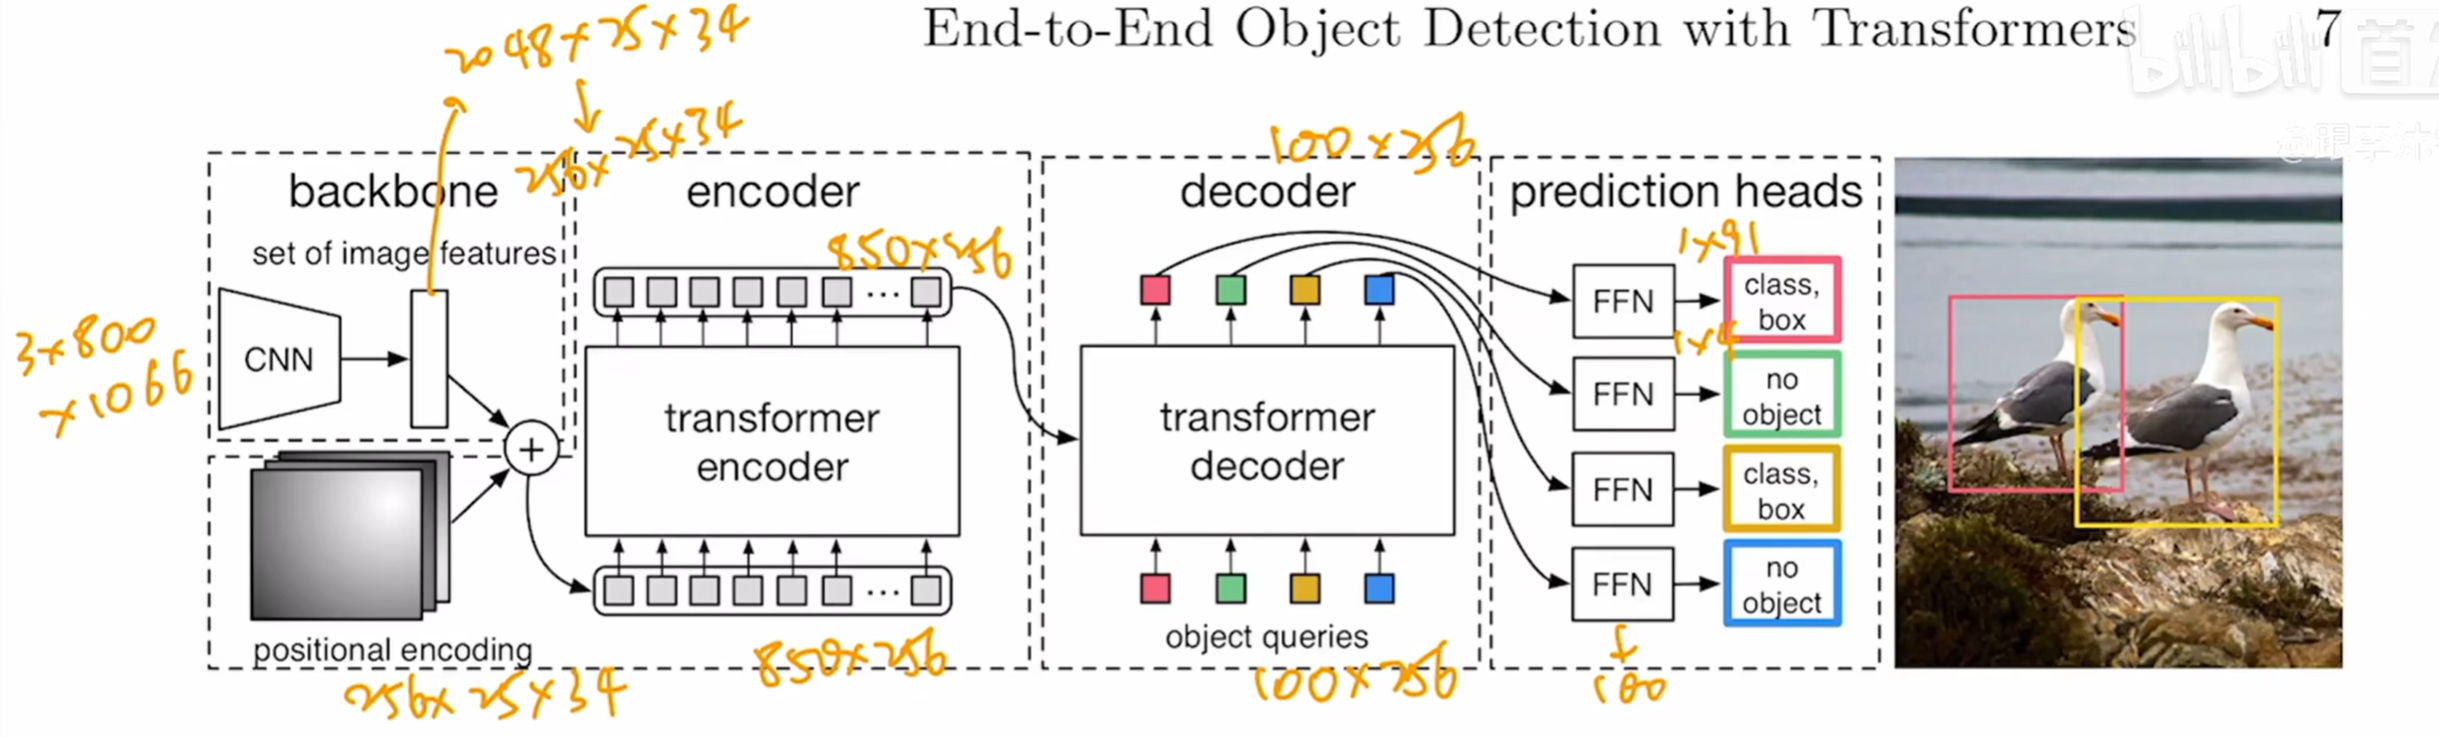

这里如上图所示，Ground Truth 只有两个框，在训练时，通过计算这100个预测的框和这两个Ground Truth框之间的 matching loss，决定哪两个框是独一无二的对应到 红色和黄色的 Ground Truth框。决定好匹配关系后，就像普通的目标检测一样，算一个分类的loss和一个banding box 的loss。对于剩下的98个框，被标记为没有物体（no object）即背景类

## 方法

分两块：1、基于集合的目标函数怎么做，作者如何通过二分图匹配把预测的框和GT框连接在一起，算得目标函数  2、detr具体模型架构

### 目标函数部分

detr模型最后输出是一个固定集合，无论图片是什么，最后都会输出n个（本文n=100）

问题：detr每次都会出100个输出，但是实际上一个图片的GT的bounding box可能只有几个，如何匹配？如何计算loss？怎么知道哪个预测框对应GT框？

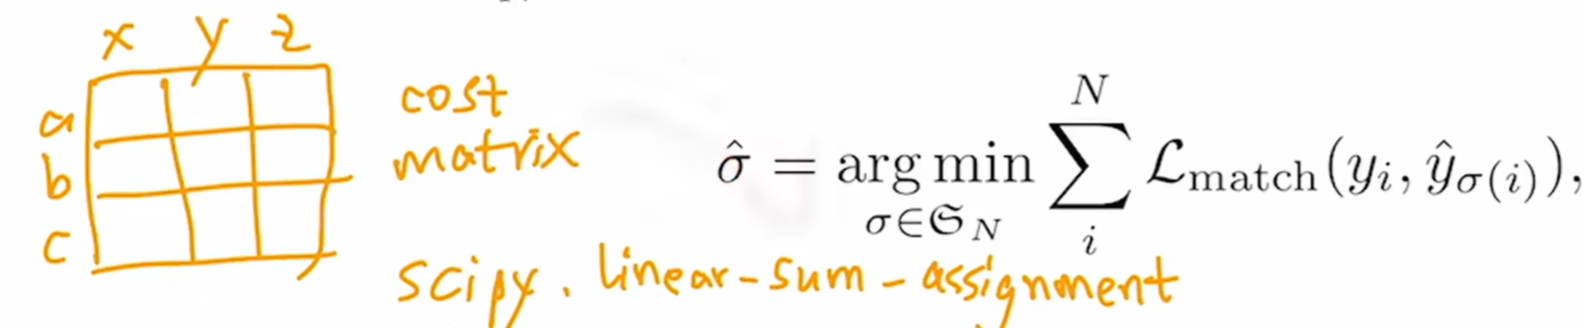

二分图匹配——匈牙利算法

scipy包提供的linear sum assignment

a,b,c看成100个预测框，x,y,z看成GT框，损失矩阵未必都是正方形


损失矩阵的值应该放些什么？loss包含两部分：分类loss、出框的准确度

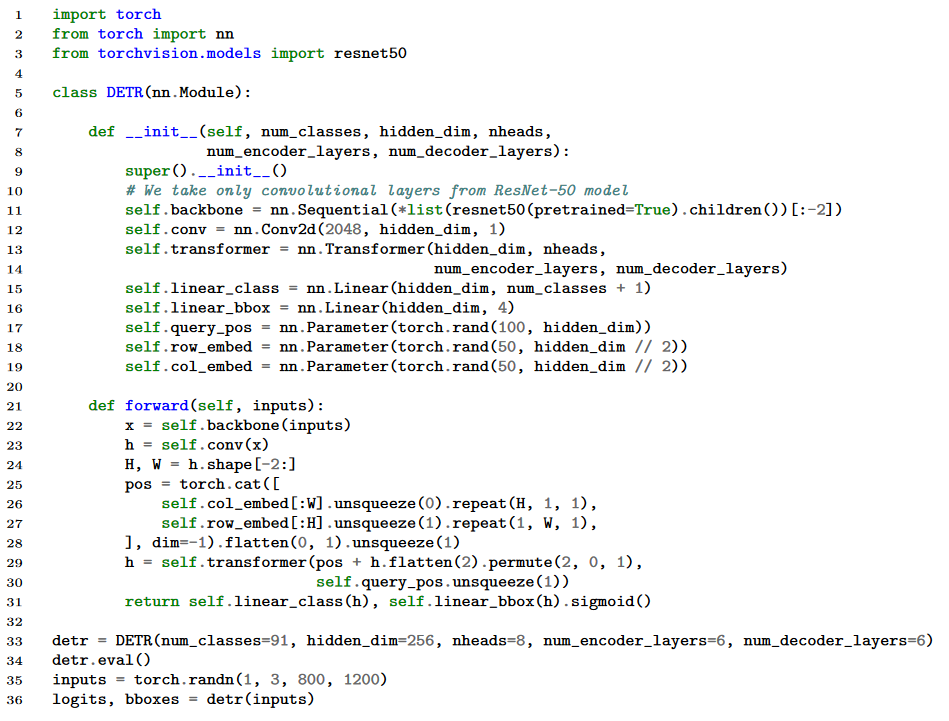

## 结果比较
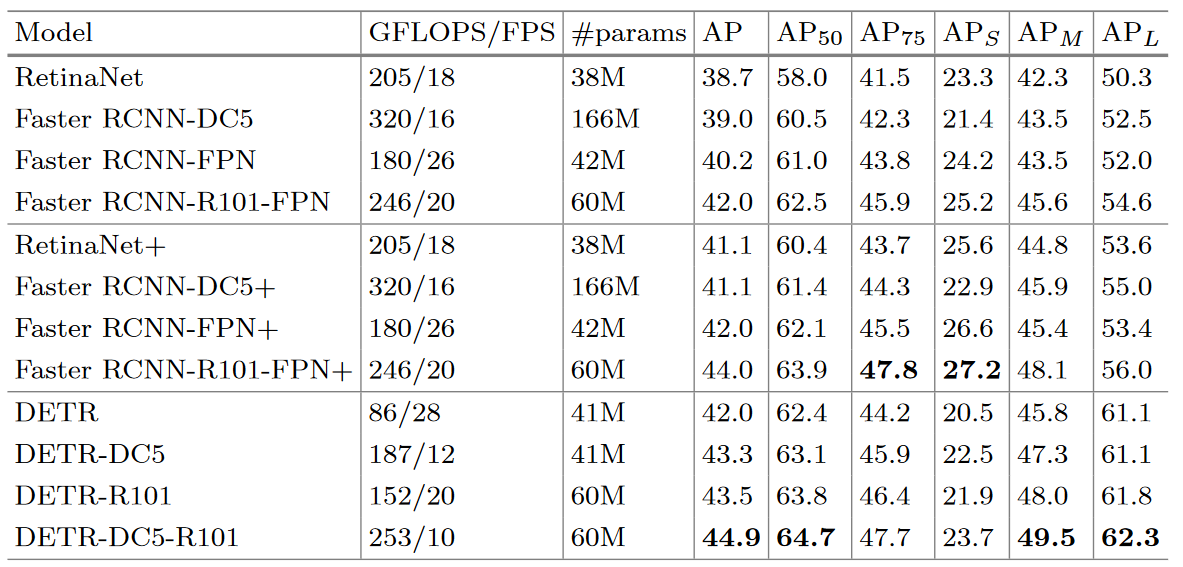

表1detr和faster RCNN的对比

+表示用更好的训练策略把三个模型重新训练一遍

gflops参数：每秒进行的浮点运算次数

gflops越小，模型越小，跑起来越快？X

如果更关心速度，比较fps

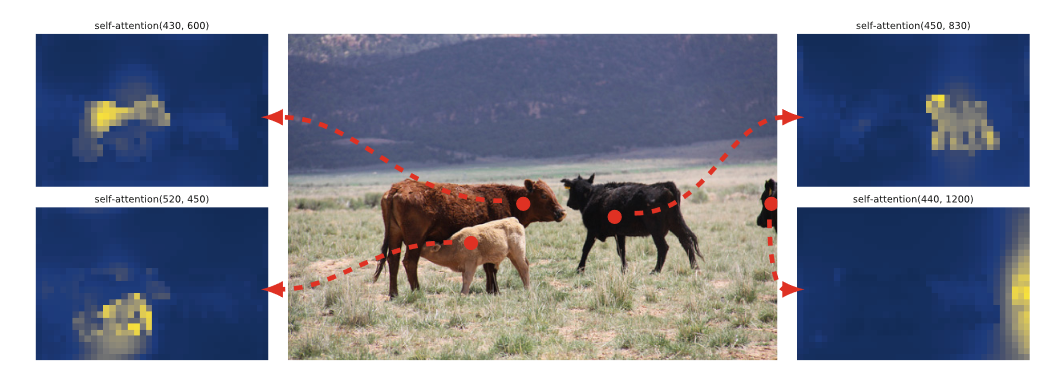

该图将 Transformer encoder这个编码器的自注意力进行可视化。在牛上点一些点作为基准点，计算基准点与该图中其他点的自注意力，可以看出自注意力是如何分布的？由图可知，自注意力已经做的十分好的。已经基本把牛的形状恢复出来了，甚至有些实例分割出来的mask的形状了。对于遮挡很严重的情况，也能区分的很清晰。

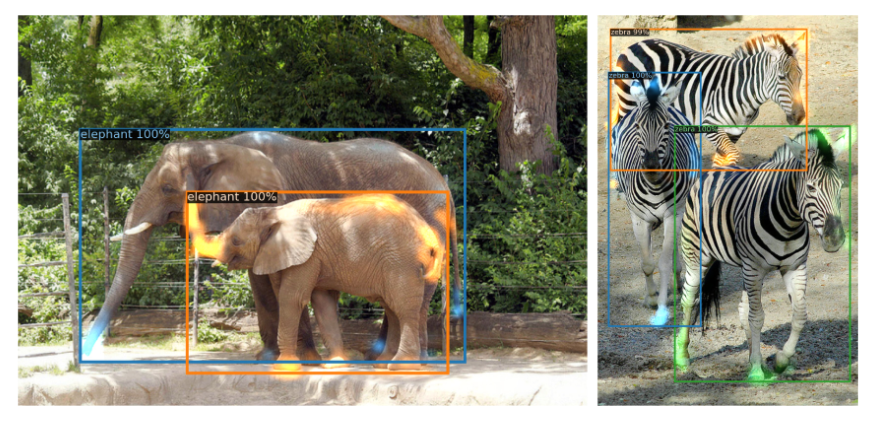
Transformer解码器，该图将每个物体的自注意力使用不同颜色表示出来。可以发现，对于遮挡很严重的情况，也能将轮廓区分的很清晰。

所以说两者均不能少，encoder在学习全局的特征，尽可能让物体之间分的开，但是对于头、尾巴等极值点，最外围的这些点就需要交给decoder来做。Decoder将注意力被放到学习边缘信息，如何更好的区分物体以及解决遮挡问题

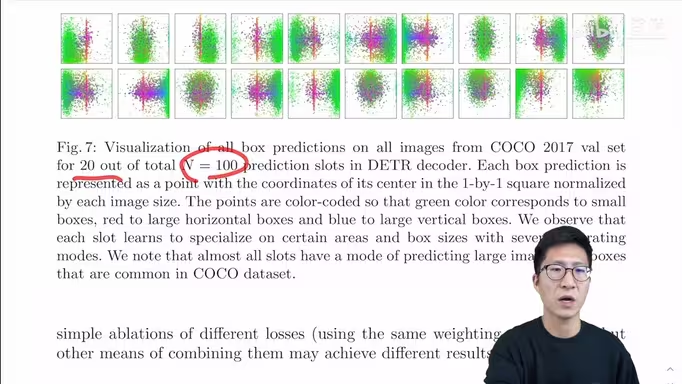
到底学了什么（绿色代表小的bounding box，红色代表大的横向bounding box，蓝色代表大的竖向bounding box）object query和anchor有些像，anchor是提前定一些bounding box，把预测和这些提前定好的bounding box对比。

object query是可以学习的，以第一个子图为例，他学到最后  相当于每次给他一张图片，他会去询问图片的左下角：你有没有看到一些小的物体啊？如果有，告诉我。或者说 问中间，有没有看到大的横向的物体啊？如果有答案，则返回答案，即对应的banding box。没找到则返回什么也没有。

### 代码

### 数据处理

dataloader中设置了utils.collate_fn，通过CocoDetection得到了img和target两个list后，会进入collate_fn进行分装，将图像分装成NestedTensor（图片加mask）

图片全都pad成每一个batch中的最大高宽，图片[batch , c,batch中的最大h，batch中的最大w]
mask就是只是指示图像原本的大小，原来图像的大小范围填充False，pad的范围填充True （shape:[batch,h,w]）

## 网络架构